# Adding the missing position angle to the 3XMM-DR8 observation table

In [1]:
import os

import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join
from astropy.io import fits

import pandas as pd
import altair as alt

%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm
#
import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

home = os.path.expanduser('~')

In [3]:
wdir = f'{home}/XMM/3XMM'
t3xmm = Table.read(f'{wdir}/3xmmdr8_obslist.fits')
t3xmm.info()

<Table masked=True length=10242>
   name    dtype  n_bad
--------- ------- -----
  REVOLUT  bytes4     0
   OBS_ID bytes10     0
 ODF_VERS  bytes3     0
       RA float32     0
      DEC float32     0
   TARGET bytes28     0
OBS_CLASS   int16     0
     NDET   int16     0
 NDETGOOD   int16     0
  PN_NEXP   int16  1924
  PN_FILT  bytes3     0
  PN_MODE  bytes5     0
  PN_TEXP   int32     0
  M1_NEXP   int16   407
  M1_FILT  bytes3     0
  M1_MODE  bytes5     0
  M1_TEXP   int32     0
  M2_NEXP   int16   351
  M2_FILT  bytes3     0
  M2_MODE  bytes5     0
  M2_TEXP   int32     0


The `OBS_ID` column in this 3XMM table is bytesXX type, I will convert it to integer in order to match it with the observation log dump.

In [4]:
obsid = [int(x) for x in t3xmm['OBS_ID']]
t3xmm['OBS_ID'] = obsid

Now read the observation log dump with the `observation_id` and position angle. The `observation_id` column needs renaming for the table inner join operation.

**NOTE:** For some stupid reason, the dumped RA is in hours. Need correcting.

In [5]:
tdump = Table.read(f'{wdir}/exp_dump_16901.csv',delimiter=';')
tdump.rename_column('observation_id','OBS_ID')
del tdump['col4']
tdump['ra1'] = tdump['ra1']*15.0

In [6]:
t3xmm.info()
tdump.info()

<Table masked=True length=10242>
   name    dtype  n_bad
--------- ------- -----
  REVOLUT  bytes4     0
   OBS_ID   int64     0
 ODF_VERS  bytes3     0
       RA float32     0
      DEC float32     0
   TARGET bytes28     0
OBS_CLASS   int16     0
     NDET   int16     0
 NDETGOOD   int16     0
  PN_NEXP   int16  1924
  PN_FILT  bytes3     0
  PN_MODE  bytes5     0
  PN_TEXP   int32     0
  M1_NEXP   int16   407
  M1_FILT  bytes3     0
  M1_MODE  bytes5     0
  M1_TEXP   int32     0
  M2_NEXP   int16   351
  M2_FILT  bytes3     0
  M2_MODE  bytes5     0
  M2_TEXP   int32     0
<Table masked=True length=33170>
 name   dtype 
------ -------
OBS_ID   int64
   ra1 float64
  dec1 float64
    pa float64


In [7]:
tout = join(t3xmm,tdump,keys='OBS_ID')

In [8]:
tout.info()

<Table masked=True length=9420>
   name    dtype  n_bad
--------- ------- -----
  REVOLUT  bytes4     0
   OBS_ID   int64     0
 ODF_VERS  bytes3     0
       RA float32     0
      DEC float32     0
   TARGET bytes28     0
OBS_CLASS   int16     0
     NDET   int16     0
 NDETGOOD   int16     0
  PN_NEXP   int16  1769
  PN_FILT  bytes3     0
  PN_MODE  bytes5     0
  PN_TEXP   int32     0
  M1_NEXP   int16   244
  M1_FILT  bytes3     0
  M1_MODE  bytes5     0
  M1_TEXP   int32     0
  M2_NEXP   int16   208
  M2_FILT  bytes3     0
  M2_MODE  bytes5     0
  M2_TEXP   int32     0
      ra1 float64     0
     dec1 float64     0
       pa float64     0


In [53]:
#
# consistency checks
#
xobsid = tout['OBS_ID']
c1 = SkyCoord(ra=tout['RA'],dec=tout['DEC'], frame="icrs", unit="deg")
c2 = SkyCoord(ra=tout['ra1'],dec=tout['dec1'], frame="icrs", unit="deg")

In [10]:
#
diff = c1.separation(c2).arcsec

In [11]:
print (np.min(diff),np.max(diff))

0.22159580206672458 200008.8615734346


In [12]:
# add the diff as a new column
tout['offset'] = diff

In [13]:
df = tout.to_pandas()

/home/ivaltchanov/miniconda3/envs/pyxspec/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'PN_NEXP' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ivaltchanov/miniconda3/envs/pyxspec/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'M1_NEXP' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ivaltchanov/miniconda3/envs/pyxspec/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'M2_NEXP' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
tout["OBS_ID","RA","DEC","NDET","ra1","dec1","pa","offset"]

OBS_ID,RA,DEC,NDET,ra1,dec1,pa,offset
int64,float32,float32,int16,float64,float64,float64,float64
110101,64.89763,56.02272,30,64.92541666665001,55.9994444444,88.2561944444,100.74222854553096
1730201,263.65793,-32.556,102,263.6749999995,-32.5816666667,91.9195277778,105.9250971860247
1730601,99.36542,6.1115,79,99.34999999995,6.13527777778,267.86975,101.84783341988394
1930101,6.5532084,10.673528,78,6.529166666669999,10.6891666667,245.126888889,101.9974090048439
1930301,193.49612,10.215167,98,193.5,10.1863888889,114.473583333,104.50715744776305
2740101,58.45729,23.414083,47,58.47958333335,23.39375,77.6548333333,103.84161333409898
2740301,187.05229,-15.758583,43,187.0575,-15.7863888889,112.982333333,101.71318166484711
2740501,167.09784,-77.61408,56,166.9704166665,-77.6155555556,210.688222222,98.53049465254449
2940101,196.76967,-23.647583,38,196.774583334,-23.6766666667,110.991444444,105.944341220499


(array([6.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 5.000e+00,
        8.354e+03, 1.029e+03, 9.000e+00, 0.000e+00, 0.000e+00, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00]),
 array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.,
        165., 180., 195., 210., 225., 240., 255., 270., 285., 300.]),
 <a list of 20 Patch objects>)

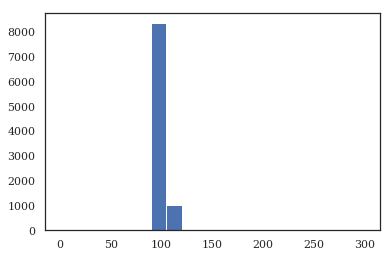

In [15]:
fig, ax = plt.subplots()
ax.hist(diff,range=(0,300),bins=20)

In [16]:
t3 = Table.read(f'{wdir}/3XMM_DR8cat_v1.0.fits.gz')

In [19]:
#obsid = '0083960101' # PA=2.0
#obsid = '0794580101' # PA=192
obsid = '0794581201' # PA=51
mask = t3['OBS_ID'] == obsid
ix = np.where(mask)
#ix

In [20]:
tq = t3[ix]

In [340]:
#isort = np.argsort(tq['EP_8_CTS'])[::-1]

In [95]:
twork = tq['RA','DEC','CCDM1','M1_RAWX','M1_RAWY','M1_OFFAX']
twork

RA,DEC,CCDM1,M1_RAWX,M1_RAWY,M1_OFFAX
deg,deg,,,,arcmin
float64,float64,int16,int16,int16,float32
308.18256759146,60.23814150221,--,--,--,15.1026
308.22088821331,60.233054841103,7,222,51,13.9256
308.23233292768,60.206963282241,7,259,130,13.4248
308.26434846027,60.054198984501,7,521,559,15.1004
308.27312869833,60.272352320207,--,--,--,13.0182
308.28034876274,60.182678116687,7,245,241,12.0045
308.28310428531,60.264639037732,7,79,30,12.5818
308.28555479738,60.335417265591,6,542,151,14.4748


In [78]:
fout1 = open(f'{wdir}/{obsid}_run_ecord_rawxy.sh','w')
fout2 = open(f'{wdir}/{obsid}_run_ecord_radec.sh','w')
#
# one output will be the ecoordconv with RAWX,RAWY and another with RA,DEC
#
m1_image = f'{wdir}/{obsid}/pps/P{obsid}M1S001IMAGE_2000.FTZ'
nt = len(twork)
for j in np.arange(nt):
    ccdnr = twork["CCDM1"].data[j]
    if (not ccdnr):
        continue
    print (f'ecoordconv imageset={m1_image} x={twork["M1_RAWX"].data[j]} y={twork["M1_RAWY"].data[j]} coordtype="raw" ccdno={ccdnr}',file=fout1)
    print (f'ecoordconv imageset={m1_image} x={twork["RA"].data[j]} y={twork["DEC"].data[j]} coordtype="eqpos" ccdno={ccdnr}',file=fout2)
fout1.close()
fout2.close()
#

In [55]:
source = SkyCoord(ra=twork['RA'],dec=twork['DEC'],unit='deg')
hdu = fits.open(m1_image)
centre1 = SkyCoord(ra=hdu[0].header['RA_NOM'],dec=hdu[0].header['DEC_NOM'],unit='deg')
centre2 = SkyCoord(ra=hdu[0].header['RA_PNT'],dec=hdu[0].header['DEC_PNT'],unit='deg')
#
# get the centre from the joined table tout
#
#iq = np.where(xobsid == int(obsid))[0]
#centre1x = c1[iq] # RA,DEC from 3xmm table
#centre2x = c2[iq] # r1,dec1 from the obs log
#centre2 = SkyCoord(ra=6.55321,dec=10.67353,unit='deg')
pa1 = source.position_angle(centre1).degree
pa2 = source.position_angle(centre2).degree
#pa1x = source.position_angle(centre1x).degree
#pa2x = source.position_angle(centre2x).degree
obs_pa = hdu[0].header['PA_PNT']

In [56]:
#xpa1 = 360 - pa1 + 180.0
#xpa2 = 360.0 - pa2 + 180.0

In [79]:
with open(f'{wdir}/{obsid}_ecoord_output_rawxy.txt','r') as fin:
    lines1 = fin.readlines()
with open(f'{wdir}/{obsid}_ecoord_output_radec.txt','r') as fin:
    lines2 = fin.readlines()
#

In [80]:
obs_pa = hdu[0].header['PA_PNT']
obs_pa

52.9392204284668

In [92]:
#
# calculate the modified Julian Date (MJD)
from astropy.time import Time
stime = Time(hdu[0].header['DATE-OBS'])
mjd = stime.mjd

In [81]:
#
# now parse the file
#
rad2deg = 180.0/np.pi
#
xphi1 = []
xtheta1 = [] # in arcmin
xra1 = []
xdec1 = []
xphi2 = []
xtheta2 = [] # in arcmin
xra2 = []
xdec2 = []
for line in lines1:
    if ('Theta' in line):
        xx = line.split()
        xtheta1.append(float(xx[2])/60.0)
        xphi1.append(float(xx[3])*rad2deg)
    if ('DEC' in line):
        xx = line.split()
        xra1.append(float(xx[2]))
        xdec1.append(float(xx[3]))
#
for line in lines2:
    if ('Theta' in line):
        xx = line.split()
        xtheta2.append(float(xx[2])/60.0)
        xphi2.append(float(xx[3])*rad2deg)
    if ('DEC' in line):
        xx = line.split()
        xra2.append(float(xx[2]))
        xdec2.append(float(xx[3]))
#

## Calculating the azymuthal angle

We calculate the azymuthal angle using the source `RA`, `Dec` and the nominal telescope position of the boresight, as encoded in the FITS header keywords `RA_NOM` and `DEC_NOM`.

This is a two step process: 
1. We calculate the position angle of the source with resect to the boresight. This gives us the sky position angle measured East of North.
2. The position angle in the focal plane is calculated by subtracting the focal plane position angle (`PA_PNT` keyword)
3. And finally we swap the angle aroung 180 deg to match zero azymuth direction, and to match the output from `ecoordconv`.

We did a number of tests with `OBS_ID` at different focal plane position angles, in order to validate the method throug a comparison with the output frmo `ecoordconv` XMM-SAS task.

In [94]:
#
# apply boresight offset
#
borefile = fits.open('/ccf/valid/XMM_BORESIGHT_0029.CCF')
m1b = borefile['EMOS1_ANGVAR']
# find the index of the nearest MJD
#
idx = np.argmin(np.abs(m1b.data['MOD_JD'] - mjd))
dphi = m1b.data['DELTAPHI'][idx]*rad2deg
dtheta = m1b.data['DELTATHETA'][idx]*rad2deg
print (dphi,dtheta)

3.212000798396756e-05 -0.0004942571573604742


In [82]:
xsource = SkyCoord(ra=xra,dec=xdec,unit='deg')
qxpa1 = (xsource.position_angle(centre1).degree - obs_pa) % 360.0
qxpa2 = (xsource.position_angle(centre2).degree - obs_pa) % 360.0
#qxpa1x = (xsource.position_angle(centre1x).degree - obs_pa) % 360.0
#qxpa2x = (xsource.position_angle(centre2x).degree - obs_pa) % 360.0
#i1 = np.where(qxpa1 >= 180)[0]
#qxpa1[i1] = 360.0 - qxpa1[i1] + 180.0
#i1 = np.where(qxpa1 < 180)[0]
#qxpa1[i1] = 180 - qxpa1[i1]
qxpa1 = (180.0 - qxpa1) % 360.0
qxpa2 = (180.0 - qxpa2) % 360.0
#qxpa1x = (180.0 - qxpa1x) % 360.0
#qxpa2x = (180.0 - qxpa2x) % 360.0
#
#i1 = np.where(qxpa2 >= 180)[0]
#qxpa2[i1] = 360.0 - qxpa2[i1] + 180.0
#i1 = np.where(qxpa2 < 180)[0]
#qxpa2[i1] = 180 - qxpa2[i1]
#qxpa2 = 360.0 - qxpa2 + 180.0
delta11 = qxpa1 - xphi1
delta12 = qxpa1 - xphi2
#delta1x = qxpa1x - xphi
#i1 = np.where(delta1 >= 360.0)[0]
#delta1[i1] -= 360.0
delta21 = qxpa2 - xphi1
delta22 = qxpa2 - xphi2
#delta2x = qxpa2x - xphi
#i1 = np.where(delta2 >= 360.0)[0]
#delta2[i1] -= 360.0


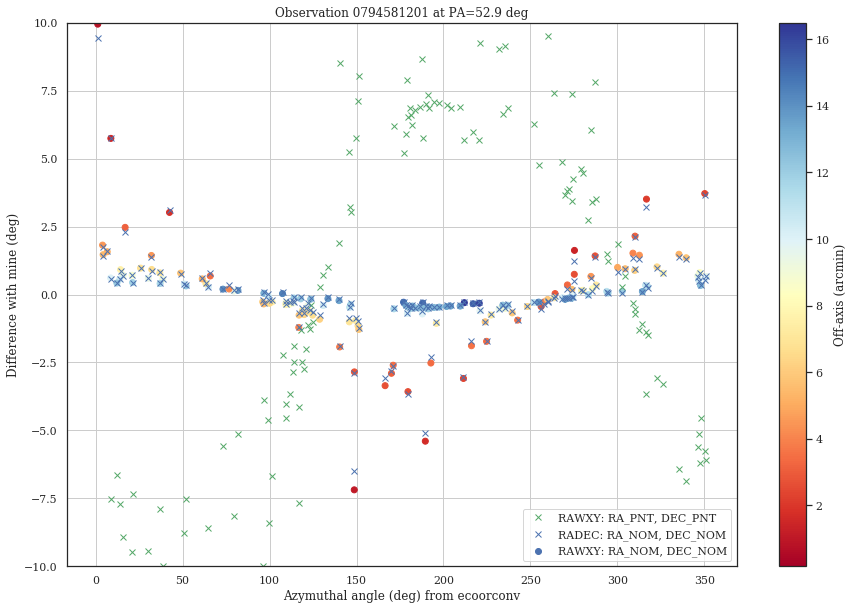

In [88]:
cm = plt.cm.get_cmap('RdYlBu')
fig, ax = plt.subplots(figsize=(15,10))
p1 = ax.scatter(xphi,delta11,c=xtheta,label='RAWXY: RA_NOM, DEC_NOM',cmap=cm)
#ax.scatter(xphi,delta2x,label='RA_NOM, DEC_NOM')
ax.plot(xphi,delta21,'gx',label='RAWXY: RA_PNT, DEC_PNT')
ax.plot(xphi,delta12,'bx',label='RADEC: RA_NOM, DEC_NOM')
#ax.plot(xphi,delta22,'r^',label='RADEC: RA_PNT, DEC_PNT')
ax.set_ylim((-10,10))
ax.set_xlabel("Azymuthal angle (deg) from ecoorconv")
ax.set_ylabel("Difference with mine (deg)")
ax.set_title(f'Observation {hdu[0].header["OBS_ID"]} at PA={hdu[0].header["PA_PNT"]:.1f} deg')
ax.grid()
cbar = plt.colorbar(p1)
cbar.set_label('Off-axis (arcmin)')
ax.legend();

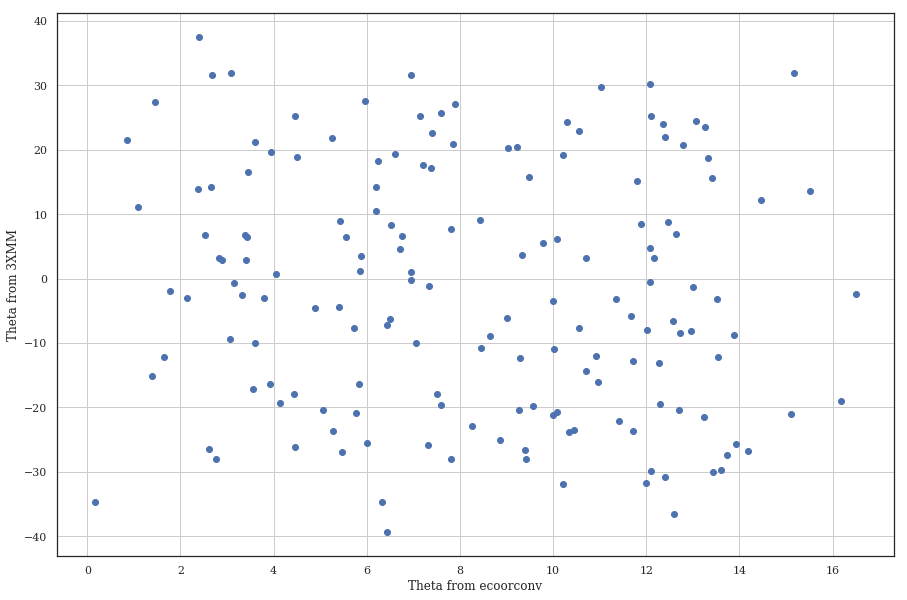

In [107]:
fig, ax = plt.subplots(figsize=(15,10))
qtheta = twork['M1_OFFAX']
qtheta = qtheta[twork['M1_RAWX'].mask == False]
p1 = ax.scatter(xtheta1,(qtheta-xtheta1)*3600)
ax.set_xlabel("Theta from ecoorconv")
ax.set_ylabel("Theta from 3XMM")
#ax.set_title(f'Observation {hdu[0].header["OBS_ID"]} at PA={hdu[0].header["PA_PNT"]:.1f} deg')
ax.grid()
#cbar = plt.colorbar(p1)
#cbar.set_label('Off-axis (arcmin)')
#ax.legend();

In [104]:
qtheta.mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

## Conclusions:

Using `RA_NOM`, `DEC_NOM` provides the best match for the azymuthal angle with the output from `ecoordconv`, although there is still some difference at a level of +/- 2 deg. This is possibly due to the fact that the nominal boresight pointing is not exactly the optical axis.

Using `RA_PNT`, `DEC_PNT` does not work well, although the keyword description says it's the optical axis. 

**Note:** The problem, however, is that the 3XMM table `3xmmdr8_obslist.fits` only lists `RA_PNT` and `DEC_PNT`, so there is no way to calculate the azymuthal angle of a source without using the observation log dump where `RA_NOM` and `DEC_NOM` are provided.

* There are some outliers at differences greater than 5 deg, all at very small off-axis angles. A one pixel offset in RAWX,RAWY can lead to large azymuthal angle difference.


## Adding the azymuth angle to the 3XMM catalogue

With the above colnclusion then we proceed by calculating the azymuthal angle for each source in the 3XMM catalogue.



In [235]:
source = SkyCoord(ra=208.47122,dec=69.25689,unit='deg')
#source = SkyCoord(ra=208.67494,dec=69.30459,unit='deg')
#source = SkyCoord(ra=208.718068,dec=69.287955,unit='deg')
#source = SkyCoord(ra=208.76576,dec=69.40051,unit='deg')
centre1 = SkyCoord(ra=208.264165,dec=69.30833,unit='deg')
centre2 = SkyCoord(ra=208.19383,dec=69.29297,unit='deg')
pa1 = source.position_angle(centre1).degree
pa2 = source.position_angle(centre2).degree
off1 = source.separation(centre1).arcsec
off2 = source.separation(centre2).arcsec
print (pa1,pa2,360-pa1+180,360-pa2+180)
#print (off1,off2,334-off1,334-off2)

305.1762636801468 290.3105117710635 234.8237363198532 249.6894882289365


238.19513263523595

In [224]:

#180*4.7249712/np.pi
#180.0*4.7042566/np.pi
180.0*0.5070985/np.pi
180.0*3.5895813/np.pi
180*5.827349/np.pi
180*0.45519997/np.pi
180*2.6770188/np.pi
180*1.5616601/np.pi
#180.0*4.1558104/np.pi
180*4.7249712/np.pi
180*4.6275644/np.pi
180*2.7625884/np.pi
180*5.2236702/np.pi


299.29425602825864

In [227]:
# CCD 1
#xx=563
#yy=132
# on CCD 3
#xx=311
#yy=411
#xx=259
#yy=359
# CCD#4
xx=24
yy=16
#
# this is the correct way to get the azymuthal angle for CCD 1
#
#360.0 - np.arctan2(xx,yy)*180.0/np.pi - 45.0
np.arctan2(xx,yy)*180.0/np.pi
#az
#360-270.7 - np.arctan2(xx,yy)*180.0/np.pi

56.309932474020215

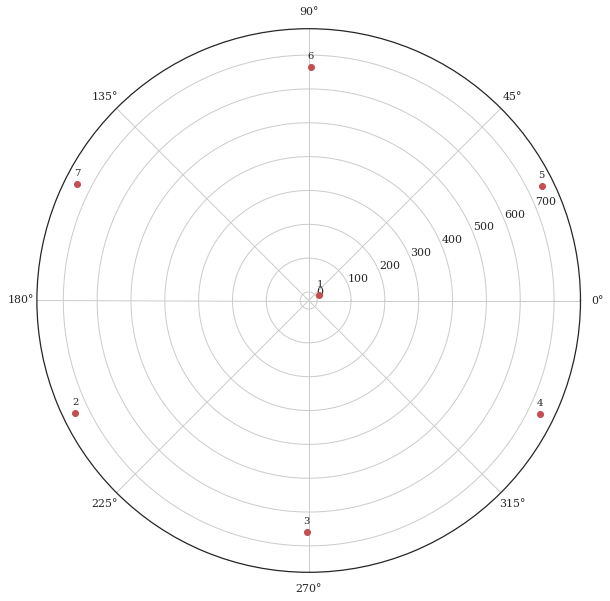

In [196]:
#
# derived from OBS_ID 0083960101 at PA approx zero (0.357 deg)
#
test = {'1':[11.333116,0.5070985], 
        '2':[740.874,3.5895813],
        '3':[658.75213,4.7042566],
        '4':[736.20138,5.827349],
        '5':[741.53297,0.45519997],
        '6':[664.35682,1.5616601],
        '7':[740.37648,2.6770188]}
#
# these are independent of the position angle of the  observation!
#
labs = [x for x in test.keys()]
rr = [test[x][0] for x in test.keys()]
theta = [test[x][1] for x in test.keys()]

import matplotlib.transforms as mtransforms

fig = plt.figure(figsize=(10,10))

# offset_copy works for polar plots also.
ax = plt.subplot(1, 1, 1, projection='polar')

trans_offset = mtransforms.offset_copy(ax.transData, fig=fig,
                                       y=6, units='dots')
ax.plot(theta,rr,'ro')

for x, y,txt in zip(theta, rr, labs):
    ax.text(x,y,txt,
             transform=trans_offset,
             horizontalalignment='center',
             verticalalignment='bottom')
plt.show()

#plt.polar(theta,rr,'o')
#plt.text(theta,rr,labs)

In [198]:
for kk in test.keys():
    print (kk,test[kk][1]*180.0/np.pi)

1 29.05460384741478
2 205.66785870908342
3 269.53404892656226
4 333.88250344978076
5 26.08103711548169
6 89.47653276397808
7 153.38187891717624


In [202]:
269.53 - 265.0

4.529999999999973

In [65]:
borefile = fits.open('/ccf/valid/XMM_BORESIGHT_0029.CCF')

In [70]:
m1b = borefile['EMOS1_ANGVAR']
m1b.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   24 / width of table in bytes                        
NAXIS2  =                 3887 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    3 / number of fields in each row                   
TTYPE1  = 'MOD_JD  '           / Observation JD - 2400000.5                     
TFORM1  = 'D       '           / format of field                                
TTYPE2  = 'DELTAPHI'           / Variation in Euler Phi angle                   
TFORM2  = 'D       '           / format of field                                
TTYPE3  = 'DELTATHETA'      

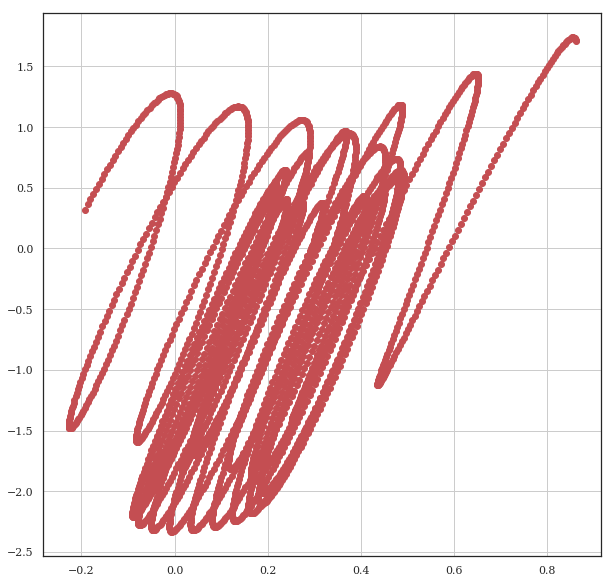

In [77]:
import matplotlib.transforms as mtransforms

rad2deg = 180.0/np.pi

fig = plt.figure(figsize=(10,10))

# offset_copy works for polar plots also.
ax = plt.subplot()

ax.plot(m1b.data['DELTAPHI']*rad2deg*3600.0,m1b.data['DELTATHETA']*rad2deg*3600.0,'ro')
ax.grid()
#for x, y,txt in zip(theta, rr, labs):
#    ax.text(x,y,txt,
#             transform=trans_offset,
#             horizontalalignment='center',
#             verticalalignment='bottom')
plt.show()

